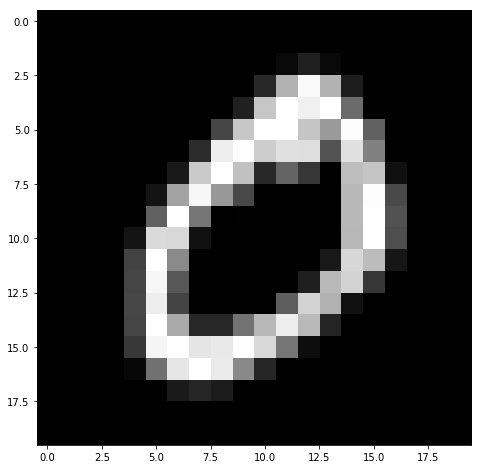

(2500, 64)
(2500, 1)
(2500, 1)
93.84


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

SZ=20
bin_n = 16 # Number of bins，將角度區分為16個方向統計直方圖

svm_params = dict( kernel_type = cv2.ml.SVM_LINEAR,
                    svm_type = cv2.ml.SVM_C_SVC,
                    C=2.67, gamma=5.383 )

affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

img = cv2.imread('digits.png',0)

cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]

plt.figure(figsize=(8,8))
plt.imshow(cells[0][0],'gray',interpolation='nearest')
plt.show()

# First half is trainData, remaining is testData
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]



######     Now training      ########################
deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.repeat(np.arange(10),250)[:,np.newaxis] #建立一維Label 0有250個，1有250個，以此類推到9 

svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)
svm.train(trainData, cv2.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')
######     Now testing      ########################
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]
print(testData.shape)
#######   Check Accuracy   ########################
mask = result==responses
print(result.shape)
print(responses.shape)
correct = np.count_nonzero(mask)
print (correct*100.0/result.size)

# 開始測試

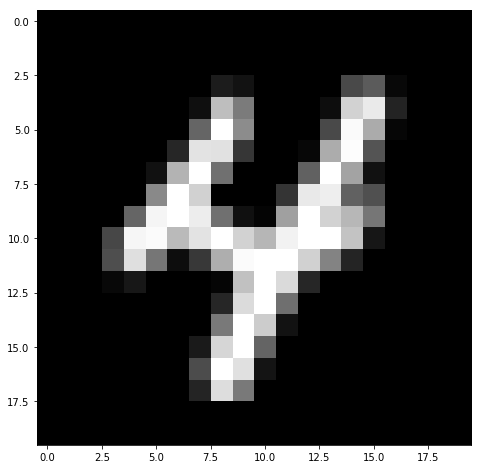

In [2]:
plt.figure(figsize=(8,8))
plt.imshow(test_cells[20][30],'gray',interpolation='nearest')
plt.show()

In [3]:
svm.load('svm_data.dat')
deskewed = deskew(test_cells[20][30])
hog_data = hog(deskewed)
testData = np.float32(hog_data).reshape(-1,bin_n*4)
res=svm.predict(testData)
print(deskewed.shape)
print(hog_data.shape)
print(res)

(20, 20)
(64,)
(0.0, array([[4.]], dtype=float32))
